This notebook shows a possible way to combine formal prediction of mutation performed by Pint with the quantiative evaluation of attractors reachability with MaBoSS.

A detailed use case of such an analysis can be found in the notebook "[Usecase - Mutations enabling tumour invasion](https://nbviewer.jupyter.org/github/colomoto/colomoto-docker/blob/master/usecases/Usecase%20-%20Mutations%20enabling%20tumour%20invasion.ipynb)".

## Model

We load a model of cell fate decision model from CellCollective using bioLQM:

In [1]:
import biolqm

In [2]:
lqm = biolqm.load("https://cellcollective.org/#5884/tumour-cell-invasion-and-migration")

Downloading 'http://api.cellcollective.org/model/export/5884?type=SBML'

## Wild-type simulation with MaBoSS

We convert the model to MaBoSS, and configure the simulation

In [3]:
import maboss

In [4]:
wt_sim = biolqm.to_maboss(lqm)

In [5]:
wt_sim.network.set_output(('Metastasis', 'Migration', 'Invasion', 'Apoptosis', 'CellCycleArrest'))

In [6]:
wt_sim.network.set_istate("ECM", [0, 1]) # ECM is active
wt_sim.network.set_istate("DNAdamage", [0.5, 0.5]) # DNAdamage can start either active or inactive

In [7]:
wt_sim.update_parameters(max_time=50)

We perform the simulation with MaBoSS, this can take several seconds.

In [8]:
wt_res = wt_sim.run()

We plot the distribution of attractors at the end of the simulations:

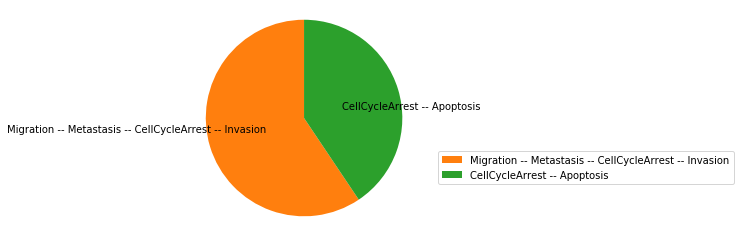

In [9]:
wt_res.plot_piechart()

## Mutation prediction with Pint

Now, we use Pint to predict mutations which remove any possible activation of apoptosis.

In [10]:
import pypint

You are using Pint version 2017-12-19 and pypint 1.4.0

In [11]:
m = biolqm.to_pint(lqm)

In [12]:
m.initial_state["ECM"] = 1
m.initial_state["DNAdamage"] = {0,1}

In [13]:
mutants = m.oneshot_mutations_for_cut("Apoptosis=1", exclude={"ECM", "DNAdamage"})
mutants

This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 5 automata. Use `maxsize` argument to change.

[{'AKT1': 1},
 {'ERK': 1},
 {'ZEB2': 1},
 {'AKT2': 1},
 {'SNAI2': 1, 'miR203': 1, 'p73': 0},
 {'SNAI2': 1, 'ZEB1': 1, 'miR203': 1},
 {'miR203': 1, 'p53': 0, 'p73': 0},
 {'ZEB1': 1, 'miR203': 1, 'p53': 0},
 {'NICD': 1, 'SNAI2': 1, 'p73': 0},
 {'NICD': 1, 'SNAI2': 1, 'ZEB1': 1},
 {'SNAI2': 1, 'p63': 0, 'p73': 0},
 {'SNAI2': 1, 'ZEB1': 1, 'p63': 0},
 {'NICD': 1, 'p53': 0, 'p73': 0},
 {'NICD': 1, 'ZEB1': 1, 'p53': 0},
 {'p53': 0, 'p63': 0, 'p73': 0},
 {'ZEB1': 1, 'p53': 0, 'p63': 0}]

Each returned solution gives a combination of mutations which are guaranteed to remove the capability to activate apoptosis, even transiently.

## Collecting experiments

Among the results returned by Pint, we want to try any potential double-mutant that may be sufficient to remove the reachability of a *stable* apoptosis.

We use Python standard library functions to compute all the couple of mutations in each predicted mutations, and then merge these couples in a single set of candidate double-mutants.

In [14]:
from itertools import combinations
from functools import reduce

In [15]:
mutant_combinations = [combinations(m.items(), 2) for m in mutants if len(m) >= 2]
candidates = reduce(set.union, mutant_combinations, set())
candidates

{(('NICD', 1), ('ZEB1', 1)),
 (('NICD', 1), ('p53', 0)),
 (('NICD', 1), ('p73', 0)),
 (('SNAI2', 1), ('NICD', 1)),
 (('SNAI2', 1), ('ZEB1', 1)),
 (('SNAI2', 1), ('p63', 0)),
 (('SNAI2', 1), ('p73', 0)),
 (('ZEB1', 1), ('p63', 0)),
 (('miR203', 1), ('SNAI2', 1)),
 (('miR203', 1), ('ZEB1', 1)),
 (('miR203', 1), ('p53', 0)),
 (('miR203', 1), ('p73', 0)),
 (('p53', 0), ('ZEB1', 1)),
 (('p53', 0), ('p63', 0)),
 (('p53', 0), ('p73', 0)),
 (('p73', 0), ('p63', 0))}

## Double-mutant experiments with MaBoSS

For each candidate double-mutant, we copy the MaBoSS wild-type model, apply the corresponding mutation and run the simulations. As there are 16 candidates to evaluate, the overall execution can take several minutes.

In [16]:
import matplotlib.pyplot as plt # for customizing the plots

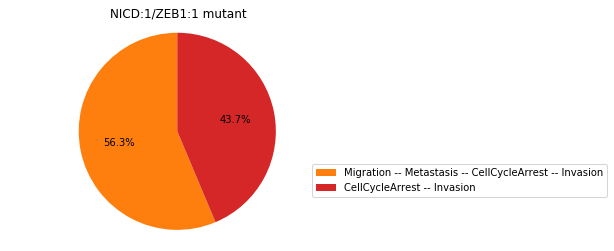

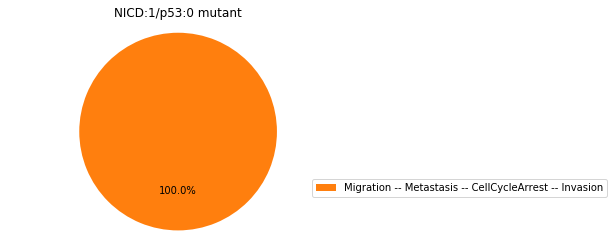

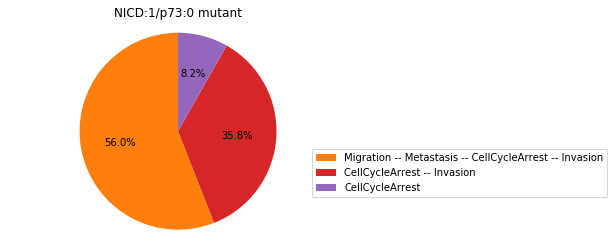

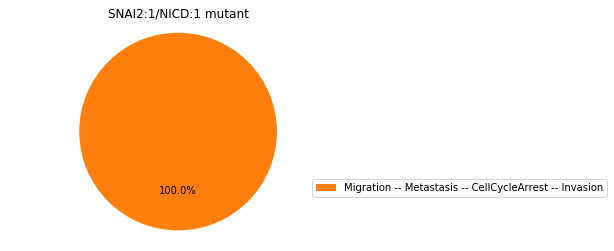

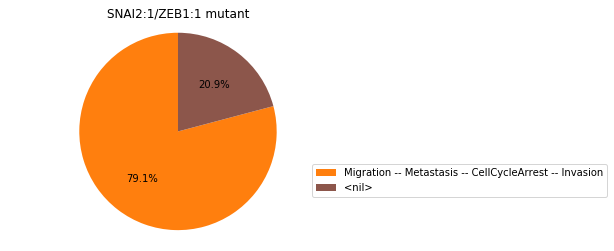

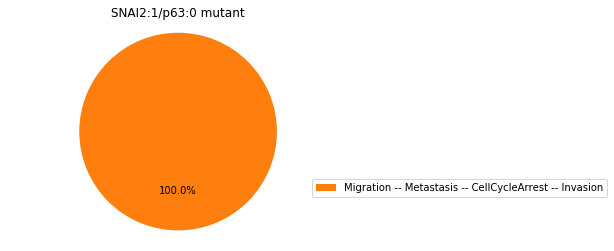

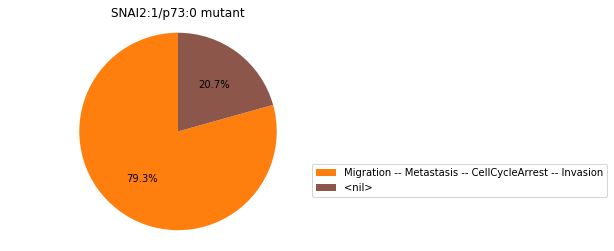

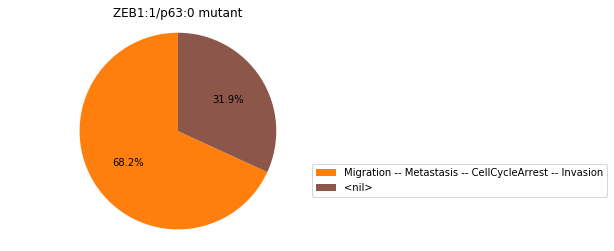

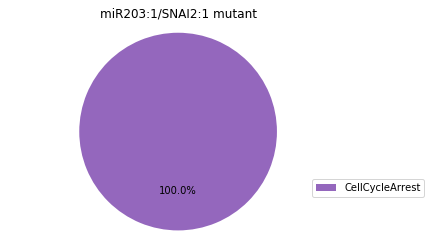

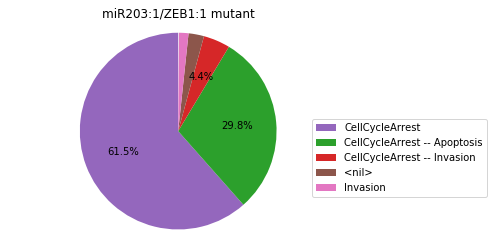

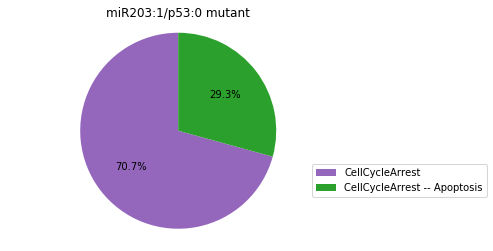

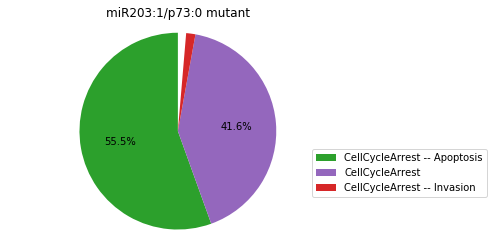

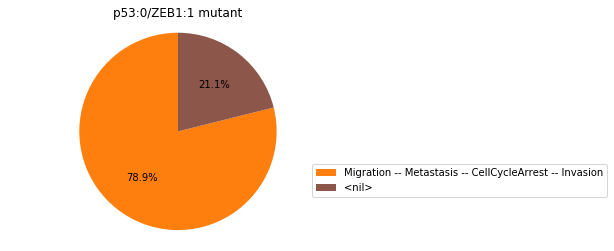

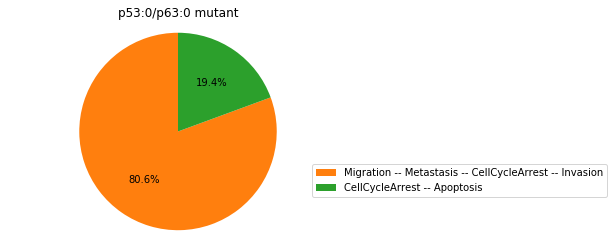

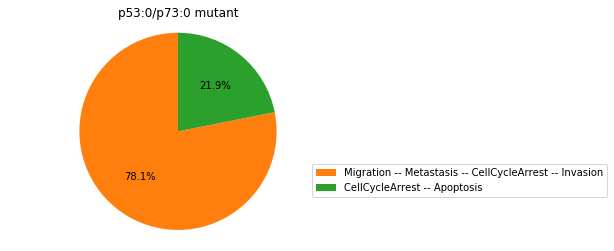

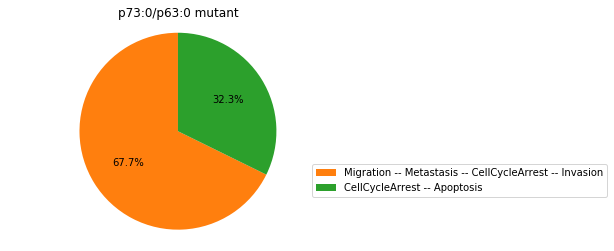

In [17]:
for mutant in sorted(candidates):
    mut_sim = wt_sim.copy()
    for (node, value) in mutant:
        mut_sim.mutate(node, "ON" if value else "OFF")
    mut_res = mut_sim.run()
    mut_res.plot_piechart(embed_labels=False, autopct=4)
    mutant_name = "/".join(["%s:%s"%m for m in mutant])
    plt.title("%s mutant" % mutant_name)